## Census Data

Data : NYC Taxis dataset 
Reference page : [nyc.gov - NYC Taxi & Limousine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)  
Direct download link :  [January 2015](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-01.csv)  

I originally followed the pyviz example (see below) that [uses data from Jan. 2015](https://s3.amazonaws.com/datashader-data/nyc_taxi_wide.parq) but having lat/lon coordinates converted into an unfamiliar cooridnates system.  
So I went directly to the original dataset.


Source : 
https://examples.pyviz.org/nyc_taxi/nyc_taxi.html



In [192]:
import pandas as pd
import datashader as ds, datashader.transfer_functions as tf, numpy as np
from datashader.utils import lnglat_to_meters
import geoviews as gv

In [178]:
dtypes = {"passenger_count" : float ,
          "pickup_longitude" :  float , 
          "pickup_latitude" :  float ,
          "dropoff_longitude" :  float ,
          "dropoff_latitude" :  float ,}

df = pd.read_csv("data/yellow_tripdata_2015-01.csv", 
                 usecols=list(dtypes.keys()), 
                 dtype=dtypes, 
                 header=0, 
                )

#df = df[ (df["pickup_latitude"] != 0) & (df["pickup_longitude"] != 0) ]

# NYC 
#   South West point 
swp = (40.685008990727844, -74.0260417262735)
#   North East point : 
nep = 40.835203923628285, -73.81864372141794

pickup_lat_filter = (df["pickup_latitude"] >= swp[0]) & (df["pickup_latitude"] <= nep[0])
pickup_lon_filter = (df["pickup_longitude"] >= swp[1]) & (df["pickup_longitude"] <= nep[1])

dropoff_lat_filter = (df["dropoff_latitude"] >= swp[0]) & (df["dropoff_latitude"] <= nep[0])
dropoff_lon_filter = (df["dropoff_longitude"] >= swp[1]) & (df["dropoff_longitude"] <= nep[1])

df = df[ pickup_lat_filter  &
         pickup_lon_filter  &
         dropoff_lat_filter &
         dropoff_lon_filter ]

In [187]:
# converts  lat/lon to y/x values, needed for the map
pickup_x, pickup_y = lnglat_to_meters(df.pickup_longitude, df.pickup_latitude)
dropoff_x, dropoff_y = lnglat_to_meters(df.dropoff_longitude, df.dropoff_latitude)

df = df.join( pd.DataFrame({   'pickup_x':pickup_x,
                          'pickup_y':pickup_y,
                          'dropoff_x':dropoff_x,
                          'dropoff_y':dropoff_y,  
                      })  )

In [188]:
df.head()

passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0              1.0        -73.993896        40.750111         -73.974785   
1              1.0        -74.001648        40.724243         -73.994415   
2              1.0        -73.963341        40.802788         -73.951820   
3              1.0        -74.009087        40.713818         -74.004326   
4              1.0        -73.971176        40.762428         -74.004181   

   dropoff_latitude      pickup_x      pickup_y     dropoff_x     dropoff_y  
0         40.750618 -8.236963e+06  4.975553e+06 -8.234835e+06  4.975627e+06  
1         40.759109 -8.237826e+06  4.971752e+06 -8.237021e+06  4.976875e+06  
2         40.824413 -8.233561e+06  4.983296e+06 -8.232279e+06  4.986477e+06  
3         40.719986 -8.238654e+06  4.970221e+06 -8.238124e+06  4.971127e+06  
4         40.742653 -8.234434e+06  4.977363e+06 -8.238108e+06  4.974457e+06

In [189]:
df.describe() 

passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
count     1.174202e+07      1.174202e+07     1.174202e+07       1.174202e+07   
mean      1.686392e+00     -7.397855e+01     4.075363e+01      -7.397683e+01   
std       1.344583e+00      2.323404e-02     2.168489e-02       2.412641e-02   
min       0.000000e+00     -7.402592e+01     4.068501e+01      -7.402604e+01   
25%       1.000000e+00     -7.399203e+01     4.073902e+01      -7.399151e+01   
50%       1.000000e+00     -7.398216e+01     4.075503e+01      -7.398077e+01   
75%       2.000000e+00     -7.396912e+01     4.076839e+01      -7.396603e+01   
max       9.000000e+00     -7.381865e+01     4.083520e+01      -7.381865e+01   

       dropoff_latitude      pickup_x      pickup_y     dropoff_x  \
count      1.174202e+07  1.174202e+07  1.174202e+07  1.174202e+07   
mean       4.075391e+01 -8.235255e+06  4.976071e+06 -8.235063e+06   
std        2.409078e-02  2.586402e+03  3.186610e+03  2.685740e+03   
min        4.068501e+01 -8.240527e+06  4.965991e+06 -8.240541e+06   
25%        4.073837e+01 -8.236755e+06  4.973923e+06 -8.236697e+06   
50%        4.075526e+01 -8.235657e+06  4.976275e+06 -8.235501e+06   
75%        4.076943e+01 -8.234205e+06  4.978240e+06 -8.233861e+06   
max        4.083520e+01 -8.217454e+06  4.988064e+06 -8.217454e+06   

          dropoff_y  
count  1.174202e+07  
mean   4.976111e+06  
std    3.540192e+03  
min    4.965991e+06  
25%    4.973827e+06  
50%    4.976309e+06  
75%    4.978392e+06  
max    4.988064e+06

In [88]:
# compute the trip duration, in seconds
df['duration'] = (pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])).dt.total_seconds()

In [91]:
# exclude outliers : all the trips during more than 6 hours
df = df[ df['duration']  <= 6*60*60 ]
print(len(df))

11833410


In [93]:
print( 'pickup',   df['tpep_pickup_datetime'].min(), df['tpep_pickup_datetime'].max() ) 
print( 'dropoff',   df['tpep_dropoff_datetime'].min(), df['tpep_dropoff_datetime'].max() ) 

pickup 2015-01-01 00:00:00 2015-01-31 23:59:59
dropoff 2015-01-01 00:00:00 2015-02-01 00:59:33


In [95]:
df.sort_values('duration', ascending=False).head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
6560592   2015-01-14 18:00:02            2015-01-15                1   
9715340   2015-01-25 18:01:33            2015-01-26                2   
204448    2015-01-10 18:01:50            2015-01-11                1   
10820783  2015-01-15 18:02:01            2015-01-16                1   
539039    2015-01-10 18:02:33            2015-01-11                2   

          trip_distance   pickup_x   pickup_y  dropoff_x  dropoff_y  \
6560592            0.65 -8234082.0  4976337.5 -8234775.0  4975270.5   
9715340            3.05 -8232625.5  4977615.0 -8236270.0  4974676.5   
204448             0.80 -8236457.5  4974616.5 -8236674.0  4975564.5   
10820783           1.38 -8234653.5  4977596.5 -8235669.5  4975310.0   
539039             1.58 -8234976.5  4981240.0 -8232719.0  4980700.5   

          fare_amount  tip_amount  dropoff_hour  pickup_hour  duration  
6560592           5.0         2.7             0           18   21598.0  
9715340          13.0         0.0             0           18   21507.0  
204448            6.0         0.0             0           18   21490.0  
10820783          7.5         0.0             0           18   21479.0  
539039            8.5         0.0             0           18   21447.0

----

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
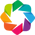

In [4]:
import holoviews as hv
import holoviews.operation.datashader as hd
from datashader.colors import Hot
hv.extension('bokeh')

In [5]:
int(df.pickup_x.min()/1000)*1000

-8254000

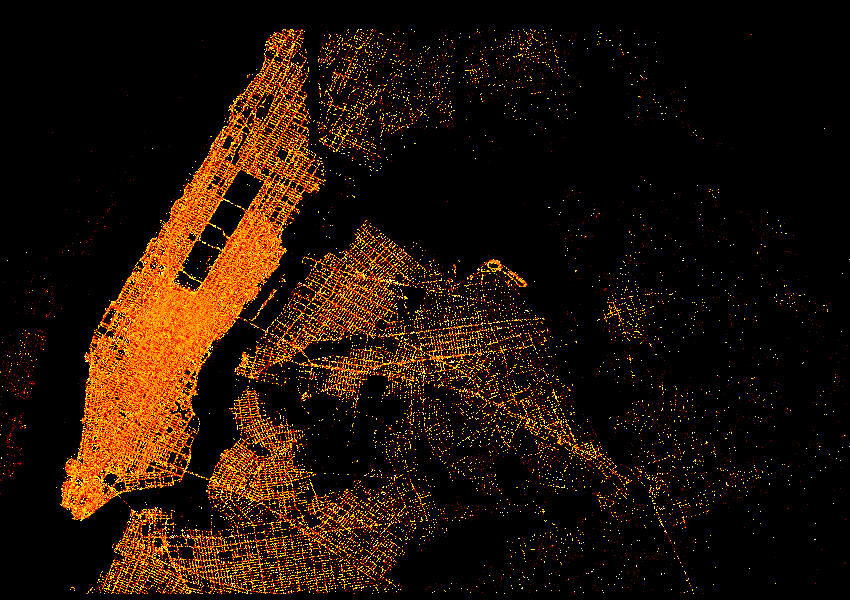

In [16]:
plot_width  = 850
plot_height = 600
x_range, y_range =(-8242000,-8210000), (4965000,4990000)

cvs = ds.Canvas(plot_width, plot_height, x_range, y_range)
agg = cvs.points (df, 'dropoff_x', 'dropoff_y',  ds.std('passenger_count'))
dropoffs = tf.set_background(tf.shade(agg, cmap=Hot, ), 'black')

agg = cvs.points (df, 'pickup_x', 'pickup_y',  ds.std('passenger_count'))
pickups = tf.set_background(tf.shade(agg, cmap=Hot, ), 'black')


dropoffs 

In [236]:
# shade from branded color #A43A8F plum) to #FFFFFF (excluded)
pickup_colors = [ "#A43A8F", 
                 "#AC4C99", "#B55EA3", "#BD70AE", "#C582B8", "#CD94C2", "#D6A5CC", "#DEB7D6", "#E6C9E0", "#EEDBEB", 
                 "#F7EDF5",
                ]

# shade from branded color #99C941 (green) to #FFFFFF (excluded)
dropoff_colors = [ "#99C941", 
                 "#A2CE52", "#ACD364", "#B5D875", "#BEDD86", "#C7E297", "#D1E6A9", "#DAEBBA", "#E3F0CB", "#ECF5DC", 
                 "#F6FAEE",
                ][::-1]


pickup_points = hv.Points(df, kdims=['pickup_x', 'pickup_y'],)
dropoff_points = hv.Points(df, kdims=['dropoff_x', 'dropoff_y'],)

pickup_shade = hv.operation.datashader.datashade(pickup_points,
                                             x_sampling=1, 
                                             y_sampling=1,
                                             aggregator=ds.sum('passenger_count'),
                                             cmap=pickup_colors,
                                            )

dropoff_shade = hv.operation.datashader.datashade(dropoff_points,
                                             x_sampling=1, 
                                             y_sampling=1,
                                             aggregator=ds.sum('passenger_count'),
                                             cmap=dropoff_colors,
                                              alpha = 128
                                            )

min_x, min_y = lnglat_to_meters(swp[1], swp[0])
max_x, max_y = lnglat_to_meters(nep[1], nep[0])

background = hv.element.tiles.CartoLight().redim.range(y=(min_y, max_y)) 

(background * pickup_shade * dropoff_shade ).opts(
                                width=1440, 
                                height=900,
                                #width=720, 
                                #height=450,
                                xaxis=None,
                                yaxis=None,
                            ) 

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [pickup_x,pickup_y]   (R,G,B,A)
      .RGB.II  :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)

### 

In [248]:
colormap = ["#613EA3","#673EA1","#6D3D9F","#733D9E","#793D9C","#7F3C9A","#863C98","#8C3B96","#923B94","#983B93","#9E3A91","#A43A8F",
            "#A43A8F","#A34788","#A25481","#A1617A","#A06E73","#9F7B6C","#9E8864","#9D955D","#9CA256","#9BAF4F","#9ABC48","#99C941"]


pickup_points = hv.Points(df, kdims=['pickup_x', 'pickup_y'],)
dropoff_points = hv.Points(df, kdims=['dropoff_x', 'dropoff_y'],)

total_shade = hv.operation.datashader.datashade(pickup_points*dropoff_points,
                                             x_sampling=1, 
                                             y_sampling=1,
                                             aggregator=ds.sum('passenger_count'),
                                             cmap=colormap,
                                             alpha=192
                                            )
min_x, min_y = lnglat_to_meters(swp[1], swp[0])
max_x, max_y = lnglat_to_meters(nep[1], nep[0])

background = hv.element.tiles.CartoLight().redim.range(y=(min_y, max_y))

(background * total_shade ).opts(
                                width=1440, 
                                height=900,
                                #width=720, 
                                #height=450,
                                xaxis=None,
                                yaxis=None,
                            )

:DynamicMap   []
   :Overlay
      .Tiles.I   :Tiles   [x,y]
      .Points.I  :RGB   [pickup_x,pickup_y]   (R,G,B,A)
      .Points.II :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)